In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
import random
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.stats import skew
from sklearn.metrics import mean_absolute_error, classification_report


In [2]:
def read_data(csv_path):
    """
    Given a path to a file, reads in the data in the file
    """
    print("Reading Data...")
    data = pd.read_csv(csv_path)
    print("Shape:", data.shape)
    return data

def clean_data(data):
    """
    Cleans data by taking string based NAs and converting to NaN.
    Assumes that the string columns are integer columns.
    """
    print("Cleaning Data...")
    data = data.replace("NA", None)
    for col_name in data.select_dtypes(exclude=['int64', 'float64']).columns:
        data[col_name] = pd.to_numeric(data[col_name], downcast="integer", errors="coerce")
    return data

def drop_duplicate_columns(data):
    """
    Iterates through columns in dataframe to find columns
    with identical values and compiles a single one of these columns into
    a set of columns to be dropped.
    """
    col_names = set()
    for x in range(data.shape[1]):
        col = data.iloc[:, x]
        for y in range(x + 1, data.shape[1]):
            check_dup = data.iloc[:, y]
            if col.equals(check_dup):
                col_names.add(data.columns.values[y])
    return data.drop(columns=list(col_names))

def impute_values(data):
    """
    Fits a simple imputer to the dataset and imputes missing
    values in the dataset.
    Might need to be changed to an iterative imputer.
    """
    print("Imputing Missing Data...")
    data = data.replace([np.inf, -np.inf], np.nan)
    matrix = data.to_numpy()
    imp = SimpleImputer()
    imp.fit(matrix)
    complete_data = pd.DataFrame(imp.transform(matrix), columns=data.columns)
    return complete_data

def correlation_heatmap(corr):
    sns.set_theme(style="white")

    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    plt.show()

def get_PCA_features(X, num):
    pca = PCA(n_components=num)
    pca_result = pca.fit_transform(X)
    print(pca.explained_variance_)
    return pca_result

def down_sample(X, y):
    """
    Down sample data to have equal numbers of
    positive and negative target variables.
    """
    print("Starting down sampling...")
    count = len(y[y>0])
    print("Count: ", count)
    indices0 = np.where(y == 0.0)[0]
    samples0 = random.choices(indices0, k=int(count))
    samples1 = list(np.where(y > 0)[0])
    samples0.extend(samples1)
    return X[samples0], y[samples0]

def remove_collinear_features(x, threshold):
    corr = x.corr()
    to_drop = []
    for i in range(len(corr.columns)):
        for j in range(i):
            c1, c2 = corr.columns[i], corr.columns[j]
            if corr[c1][c2] >= threshold:
                to_drop.append(c1)

    x = x.drop(columns = set(to_drop))
    return x

def log_skew(data):
    """
    Takes the log of the values of columns with data that is
    skewed greater than 10 standard deviations
    """
    print("Log Skewed Data...")
    data_copy = data.copy()
    for col in data_copy.columns:
        std = data[col].std()
        a = (data[col] - data[col].mean())/std
        skewval = skew(a)
        if abs(skewval) > 10:
            data_copy[col] = np.log(data_copy[col]+1.0000001 - data_copy[col].min())
    return data_copy

In [3]:
data = read_data("/Users/therafu/Documents/MyFiles/Projects/COMP/DSCI303/Loan-Default-Prediction---ICL/train_v2.csv")
cleaned_data = clean_data(data)
dropped_data = drop_duplicate_columns(cleaned_data)
imputed_data = impute_values(dropped_data)

Reading Data...
Shape: (105471, 771)
Cleaning Data...
Imputing Missing Data...


/Users/therafu/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (135,204,274,417) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
dfX = imputed_data.drop("loss", 1).drop("id", 1)
dfX_C = remove_collinear_features(dfX, 0.99)

In [6]:
def normalize(data):
    for col in data.columns:
        if data[col].std() != 0:
            data[col] = (data[col] - data[col].mean()) / data[col].std()
        else:
            data[col] = 0
    return data

# X = normalize(dfX).to_numpy()
X = normalize(dfX_C).to_numpy()

In [7]:
pca = PCA(n_components=100)
pcaX = pca.fit_transform(X)
print(sum(pca.explained_variance_ratio_))

0.878706511778228


In [8]:
base_X = X

# Split data
y = imputed_data["loss"]
trainX, trainY = base_X[:80000], y[:80000]
testX, testY = base_X[80000:], y[80000:]

# Create classification y
cls_y = y.mask(y > 0, 1).to_numpy()
cls_trainY, cls_testY = cls_y[:80000], cls_y[80000:]

# Create down sampled data
downX, downY = down_sample(trainX, trainY)
posX, posY = trainX[trainY > 0], trainY[trainY > 0]
pos_testX, pos_testY = testX[testY > 0], testY[testY > 0]

print(trainX.shape)

Starting down sampling...
Count:  7297
(80000, 478)


In [36]:
import time
def evaluate_result(result):
    print("MAE for the model", mean_absolute_error(testY, result))
    print("MAE for averages", mean_absolute_error(testY, np.ones(testY.shape[0]) * np.average(testY)))
    print("MAE for all zeros", mean_absolute_error(testY, np.zeros(testY.shape[0])))
    print("Predicted sum of Y", result.sum())
    print("Actual sum of Y", testY.sum())
    print("Predicted postives of Y", result[result>0].size)
    print("Actual postives of Y", testY[testY>0].size)
    plt.hist(result, bins=100)
    plt.yscale('log')
    plt.xlim((-2, 102))
    plt.title("Histogram of loss variable predicted by mixed model (log scale)")
    # plt.tick_params(color="white", labelcolor="white")

def evaluate_cls_result(result):
    print("MAE for the model", mean_absolute_error(cls_testY, result))
    print("MAE for all zeros", mean_absolute_error(cls_testY, np.zeros(cls_testY.shape[0])))
    print(classification_report(cls_testY, result))
    plt.hist(result, bins=2)
    plt.yscale('log')
    plt.title("Histogram of loss variable (log scale)", color="white")
    # plt.tick_params(color="white", labelcolor="white")

def evaluate_pos_result(result):
    print("MAE for the model", mean_absolute_error(pos_testY, result))
    print("MAE for all zeros", mean_absolute_error(pos_testY, np.zeros(pos_testY.shape[0])))
    print("Predicted sum of Y", result.sum())
    print("Actual sum of Y", pos_testY.sum())
    print("Predicted postives of Y", result[result>0].size)
    print("Actual postives of Y", pos_testY[pos_testY>0].size)

def predict_on_two_models(cls_model, reg_model, isolation_forest=False, boxcox_lam=None):
    """
    Create models based on model_type and fit
    to the training data given. Returns the model.
    """
    ypred1 = cls_model.predict(testX)
    if isolation_forest:
        ypred1[ypred1>0] = 0
        ypred1[ypred1<0] = 1
    X_filtered = testX[ypred1 > 0]
    print("X size: ", trainX.shape[0], "Filtered size", X_filtered.shape[0])
    ypred2 = reg_model.predict(X_filtered).astype(int)
    if boxcox_lam is not None:
        ypred2 = (inv_boxcox(ypred2, boxcox_lam)-1.000001).astype(int)
    ypred1[ypred1 > 0] = ypred2
    return ypred1

def evaluate_model(model):
    ypred = model.predict(testX)
    evaluate_result(ypred)

def evaluate_cls_model(model):
    ypred = model.predict(testX)
    evaluate_cls_result(ypred)

Text(0.5, 1.0, 'Histogram of loss variable lable (log scale)')

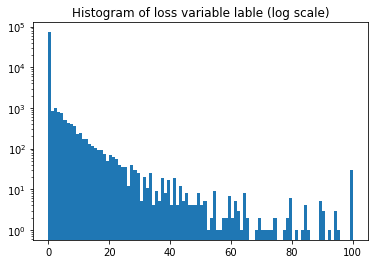

In [25]:
plt.hist(trainY, bins=100)
plt.yscale('log')
plt.title("Histogram of loss variable lable (log scale)")

In [11]:
model = DecisionTreeClassifier(max_depth=50)
model.fit(trainX, cls_trainY)
evaluate_cls_model(model)

In [30]:
model1 = DecisionTreeClassifier(max_depth=30)
model1.fit(trainX, trainY)
evaluate_model(model1)

DecisionTreeClassifier(max_depth=30)

MAE for the model 1.3812963762710533
MAE for averages 1.4342157152902693
MAE for all zeros 0.7946684464685329
Predicted sum of Y 16906
Actual sum of Y 20241.0
Predicted postives of Y 2082
Actual postives of Y 2486


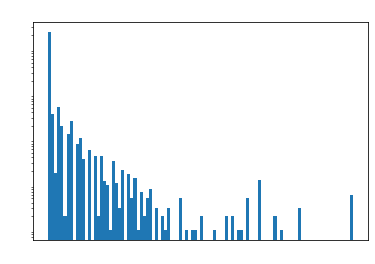

In [15]:
bc_ytrain, bc_ytrain_lambda = boxcox(trainY+1.000001)
model2 = DecisionTreeRegressor(max_depth=30)
model2.fit(trainX, bc_ytrain)
ypred = model2.predict(testX)
ypred = (inv_boxcox(ypred, bc_ytrain_lambda)-1.000001).astype(int)
evaluate_result(ypred)
plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
4099.0 2486.0 [0. 0. 0. ... 0. 0. 0.]
X size:  80000 Filtered size 4099
MAE for the model 0.9028306701739233
MAE for averages 1.4342157152902693
MAE for all zeros 0.7946684464685329
Predicted sum of Y 4099.0
Actual sum of Y 20241.0
Predicted postives of Y 4099
Actual postives of Y 2486


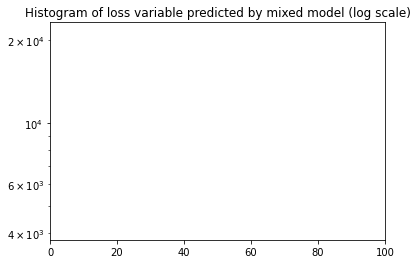

In [34]:
from sklearn.naive_bayes import GaussianNB
gnb =  GaussianNB()
ypred1 = gnb.fit(trainX, cls_trainY).predict_proba(testX)
ypred1 = ypred1[:,1]

threshold = 1 - 10**-16
print(ypred1[ypred1>threshold][:10])
ypred1[ypred1>threshold] = float('inf')
ypred1[ypred1<=threshold] = 0
ypred1[ypred1==float('inf')] = 1
print(sum(ypred1), sum(cls_testY), ypred1)
evaluate_cls_result(ypred1)

X_filtered = testX[ypred1 > 0]
print("X size: ", trainX.shape[0], "Filtered size", X_filtered.shape[0])

model1 = DecisionTreeClassifier(max_depth=50)
model1.fit(trainX, trainY)

ypred2 = model1.predict(X_filtered).astype(int)
evaluate_result(ypred1)

ypred1[ypred1 > 0] = ypred2
evaluate_result(ypred1)

/Users/therafu/venv/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


MAE for the model 0.7123787837148129
MAE for all zeros 0.09760119351419261
              precision    recall  f1-score   support

         0.0       0.91      0.23      0.37     22985
         1.0       0.10      0.78      0.18      2486

    accuracy                           0.29     25471
   macro avg       0.50      0.51      0.27     25471
weighted avg       0.83      0.29      0.35     25471

19561 25471
X size:  80000 Filtered size 19561
MAE for the model 1.351890385143889
MAE for averages 1.4342157152902693
MAE for all zeros 0.7946684464685329
Predicted sum of Y 16329
Actual sum of Y 20241.0
Predicted postives of Y 2288
Actual postives of Y 2486


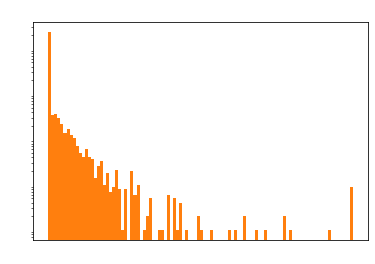

In [20]:
model8 = IsolationForest(contamination=0.8, behaviour="new")
model8.fit(trainX)
ypred = model8.predict(testX)
ypred[ypred>0] = 0
ypred[ypred<0] = 1
evaluate_cls_result(ypred)
print(sum(ypred), len(ypred))

model1 = DecisionTreeClassifier(max_depth=50)
model1.fit(trainX, trainY)

ypred = predict_on_two_models(model8, model1, isolation_forest=True)
evaluate_result(ypred)